In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# IndEng 142: Machine Learning and Data Analytics

## Set-up

In [2]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from sklearn import preprocessing

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression as logit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import roc_auc_score as AUC
from sklearn.model_selection import cross_val_score as CVS
from sklearn.ensemble import VotingClassifier as VC

# Plot styling
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 9 , 5

## Data gathering

In [3]:
main_df = pd.read_csv("train.csv")
songs_df = pd.read_csv("songs.csv")
members_df = pd.read_csv("members.csv")

In [4]:
step1_df = pd.merge(songs_df, main_df, on='song_id')
df = pd.merge(members_df, step1_df, on='msno')

In [5]:
train, test = train_test_split(df,test_size=0.3)

## Data exploration

##### Useful functions

In [6]:
def missing(df):
    missing = list()
    for col in df.columns:
        missing.append(sum(pd.isnull(df[col])))
    missing_perc = [100*x / len(df) for x in missing]
    missing_dict = dict()
    i=0
    for col in df.columns:
        missing_dict[col] = missing_perc[i]
        i=i+1
    missing_dict["Stalion"] = 100
    mis_df = pd.DataFrame([missing_dict]).T
    mis_df.plot.bar()
    return(mis_df)

def explore_distribution(df):
    colormap = plt.cm.viridis
    
    for col in df.drop('target',axis=1).columns:
        print('---------------------------------------------------------')
        ct = pd.crosstab(df[col],df["target"],margins=True).apply(lambda x: 100*x/float(x[-1]),axis=1)
        print(ct)
        ct.plot.bar(colormap=colormap)

##### Set up

In [7]:
train10_df = train.sample(frac=0.12)
main10_df = main_df.sample(frac=0.12)
songs10_df = songs_df.sample(frac=0.12)
members10_df = members_df.sample(frac=0.12)

In [8]:
train10_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,source_system_tab,source_screen_name,source_type,target
3985412,KxX+gpQrKwH03GwAKlBxCNOVpPtjI4KMT6MmbLuTV2Q=,5,22,male,9,20130831,20170919,wu2EAjrLENTdgNBiA0gaT+Nqj45AytmYHh8eZxAhQ2c=,57469,359,ELEKIBASS,SakamotoYouichi,NaN,17.0,my library,Local playlist more,local-library,1
858370,NzxFYmHEK32NaephTO2QGtxiR93Cf7U/Tp6jkoY25WE=,13,21,male,3,20120824,20170819,UOZam5rJ4q5Reu/gwMUpSBhpBWoQu7RA3PoTg83oCNk=,235990,465,鄧福如,鄧福如 Afu / 宋念宇 / 何官錠 AL,Hush,3.0,listen with,Others profile more,listen-with,1
2172925,/LxsvUP+iMKj4PYOVXb9Z0lXnaP5nXiLGuSvxJi1o7U=,1,0,NaN,3,20130721,20171004,J4qKkLIoW7aYACuTupHLAPZYmRp08en1AEux+GSUzdw=,212750,1616|1609,Alan Walker,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,Alan Walker| Jesper Borgen| Anders Froen| Gunn...,52.0,discover,Discover Feature,online-playlist,1
5866170,a5l8dCOTeGPJ6tGD9OCFFq9JE+LEIJmUd/8zTrO03dg=,1,0,NaN,3,20130201,20170911,k1oPPV9BHL8/aoaWFmN08pxLDTd/cOrB6hYWDziEJV4=,247536,465,強辯樂團 (Champion),NaN,NaN,3.0,my library,Local playlist more,local-playlist,0
2578807,wlH78luI9V33fM4ce942F7xtNKqEp4SRer3si977o0s=,1,0,NaN,7,20130901,20170924,9uh86mzC6HSoBS5G1stubXrWC/v5n1gCmP+8mniNskw=,297482,1609,Sigala,Bryn Christopher,Bryn Christopher,52.0,my library,Local playlist more,local-playlist,1


In [9]:
songs10_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
1770171,8FtD4zVGn/V6RL+RB9M5hcrsdI9TY5goB5+/Iih1fys=,221204,1609,noripy (のりぴー),noripy,Yura Mizuno/noripy,17.0
1485284,/53/7Afm/DrE0dgw0N0YQPugkd4maq24bmKjMDSnJ5c=,319135,NaN,Megahertz,Daniele Dupuis,NaN,52.0
1285676,sB07EFsfPEuiyzOhdJkvdvO8jQfQlBzYOqX8Z7FdEVg=,346534,NaN,OST-Hindi,NaN,NaN,38.0
1124269,7gRolpmtzk+dveyxkLmmmmmgE6lxYOIs84gLaRxrWUg=,270001,1616|2058,Various Artists,Gart Smith,Shalamon Baskin,52.0
2238115,F7bwTGIE20QyF7T4LyVwfdbA6fSDE9FFgGYEMpOmJDc=,133328,829,The Seekers,Athol Guy| Judith Durham| Keith Potger| Tradit...,NaN,52.0


In [10]:
members10_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
14526,V363WUO7Ql9rNM7916D3XFtmWy45MRQnPaOhEh4O7FM=,1,0,NaN,7,20151001,20170829
2157,VgegeAxBDawRuCOdGrfpjwTh7gHR0z9G1n6vYwpppuI=,10,0,NaN,9,20150723,20171024
27573,8xqgIZNaUk9zsejxX2OiNbhSvLkT7u3ei3DLohMZe5s=,1,0,NaN,4,20161213,20161216
13461,vLUH72LWZQjv+CqKIOiDpWJv0T1tJiTEtenKLP/A/dU=,1,0,NaN,4,20160904,20160907
33712,0F5EBwvchgFPIfisXZukZWSLvc+nozdgo6gdR/1SI88=,5,0,female,3,20160613,20170122


### a) Attribute Research

#####  Missing Values

,Stalion,msno,song_id,source_screen_name,source_system_tab,source_type,target
0,100.0,0.0,0.0,5.613528,0.24749,0.292221,0.0


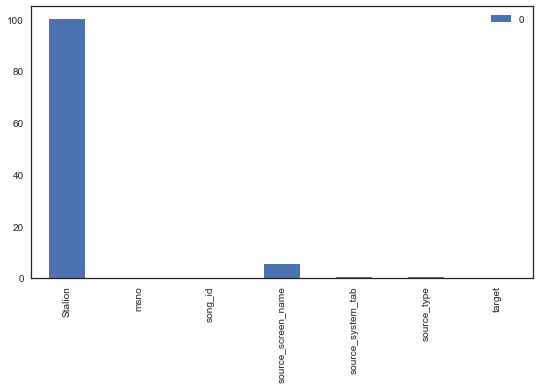

In [11]:
mis_main = missing(main10_df)
mis_main.T.head()

,Stalion,artist_name,composer,genre_ids,language,lyricist,song_id,song_length
0,100.0,0.0,46.538297,4.135608,0.0,84.675821,0.0,0.0


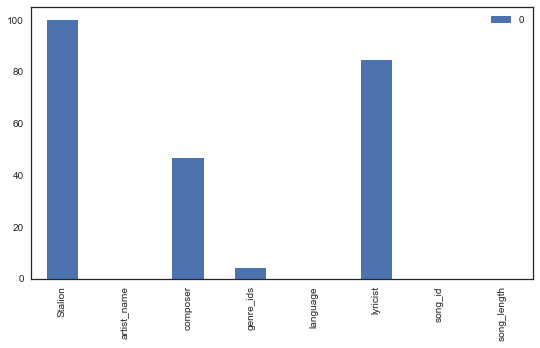

In [12]:
mis_songs = missing(songs10_df)
mis_songs.T.head()

,Stalion,bd,city,expiration_date,gender,msno,registered_via,registration_init_time
0,100.0,0.0,0.0,0.0,58.406008,0.0,0.0,0.0


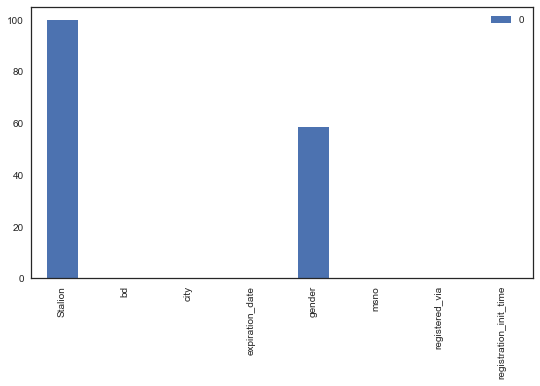

In [13]:
mis_members = missing(members10_df)
mis_members.T.head()

,Stalion,artist_name,bd,city,composer,expiration_date,gender,genre_ids,language,lyricist,msno,registered_via,registration_init_time,song_id,song_length,source_screen_name,source_system_tab,source_type,target
0,100.0,0.0,0.0,0.0,22.744811,0.0,40.064193,1.612895,0.000968,43.132002,0.0,0.0,0.0,0.0,0.0,5.662643,0.253513,0.298212,0.0


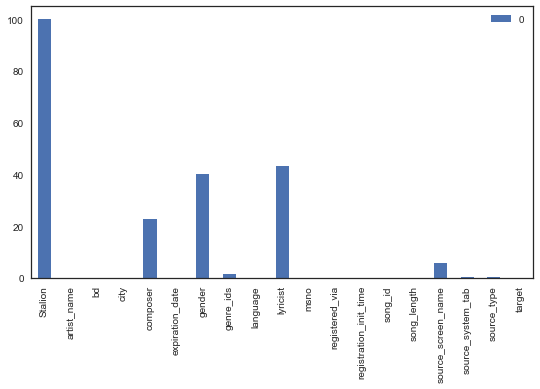

In [14]:
mis_train = missing(train10_df)
mis_train.T.head()

##### Type of Data

In [15]:
train10_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619693 entries, 3985412 to 7000962
Data columns (total 18 columns):
msno                      619693 non-null object
city                      619693 non-null int64
bd                        619693 non-null int64
gender                    371418 non-null object
registered_via            619693 non-null int64
registration_init_time    619693 non-null int64
expiration_date           619693 non-null int64
song_id                   619693 non-null object
song_length               619693 non-null int64
genre_ids                 609698 non-null object
artist_name               619693 non-null object
composer                  478745 non-null object
lyricist                  352407 non-null object
language                  619687 non-null float64
source_system_tab         618122 non-null object
source_screen_name        584602 non-null object
source_type               617845 non-null object
target                    619693 non-null int64
dtypes

##### Conclusions

### b) Distributions & Correlations

---------------------------------------------------------
target          0          1    All
city                               
1       51.090312  48.909688  100.0
3       49.595941  50.404059  100.0
4       49.435022  50.564978  100.0
5       48.641425  51.358575  100.0
6       49.765319  50.234681  100.0
7       50.263952  49.736048  100.0
8       49.604332  50.395668  100.0
9       46.333501  53.666499  100.0
10      46.414004  53.585996  100.0
11      51.103565  48.896435  100.0
12      49.931590  50.068410  100.0
13      47.730019  52.269981  100.0
14      48.763965  51.236035  100.0
15      48.902176  51.097824  100.0
16      55.520505  44.479495  100.0
17      49.129747  50.870253  100.0
18      49.811540  50.188460  100.0
19      58.122744  41.877256  100.0
20      41.983122  58.016878  100.0
21      48.098554  51.901446  100.0
22      50.592043  49.407957  100.0
All     49.660074  50.339926  100.0
---------------------------------------------------------
target          0   

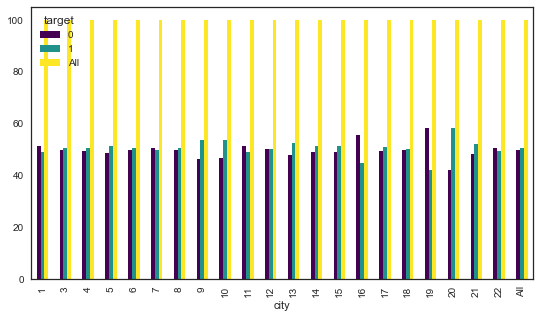

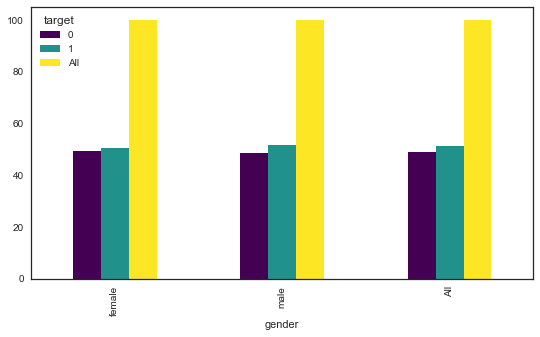

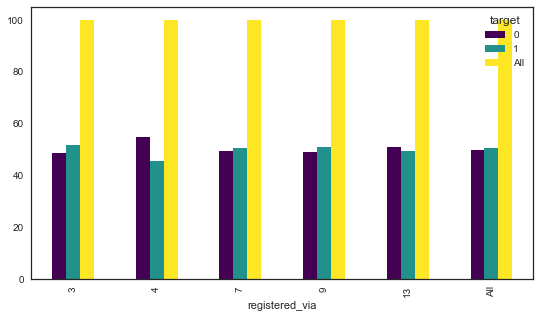

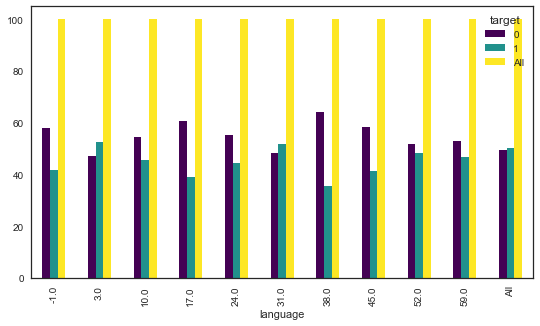

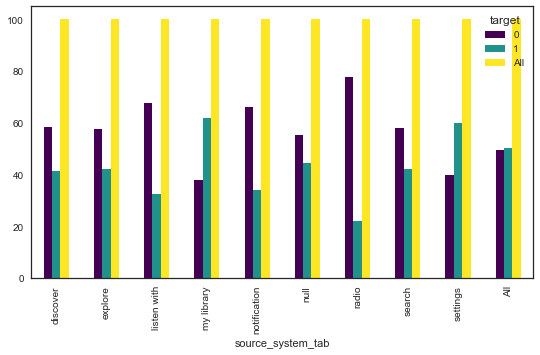

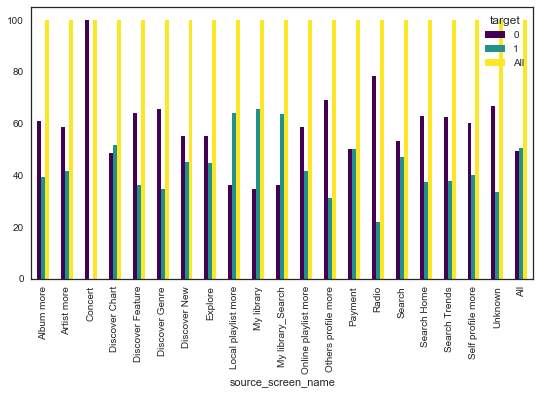

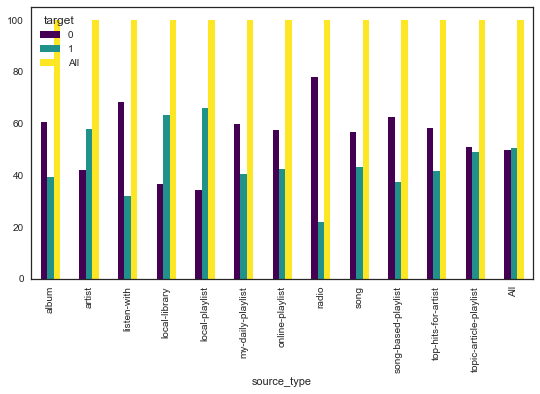

In [16]:
explore_distribution(train10_df.drop(['msno','song_id','registration_init_time','expiration_date','song_length','genre_ids','artist_name','composer','lyricist','bd'],axis=1))

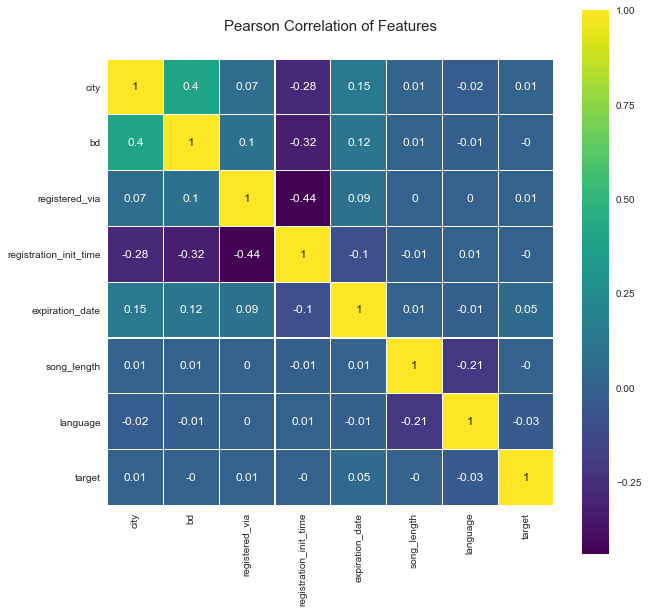

In [17]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train10_df.select_dtypes(exclude=['object']).astype(float).corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

##### Conclusions

### c) Next Steps

## Data Preparation

### Cleaning

In [18]:
def select_1(df):
    return df.drop(['composer','lyricist','gender','registration_init_time','expiration_date'],axis=1)

In [19]:
def clean_2(df):
    for col in ['genre_ids', 'source_screen_name', 'source_type', 'source_system_tab']:
        df[col].fillna('-1',inplace=True)
    df['language'].fillna(-1,inplace=True)
    return df

### Encoding

In [20]:
def encode_4(df):
    """Function for encoding categorical and non-numerical values into numerical ones"""
    encoder = preprocessing.LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = encoder.fit_transform(df[col])
    return df

### Feature Engineering

##### Discretization

In [21]:
def fe_3(df):
    """Function to make buckets and categorize song length. Possible buckets could be: 0-1.5 min | 1.5 to 3 min | 3 to 4.5 min | over 4.5 min"""
    # From https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data we know that song length is expressed in ms
    
    # Step 1: Convert to minutes
    df['song_length_min'] = df['song_length']/(60000)
    
    # Step 2: Make buckets
    df['dis_song_length'] = pd.cut(x=df['song_length_min'],bins=[0,1.5,3,4.5,1000],labels=[0,1,2,3]).astype('int')
    
    # Step 3: Drop old features and return DataFrame  
    return df.drop(['song_length_min','song_length'],axis=1)


### Pipeline

In [22]:
def pipe(df):
    df_1 = select_1(df)
    df_2 = clean_2(df_1)
    df_3 = fe_3(df_2)
    df_4 = encode_4(df_3)
    
    return df_4

### Putting the Training  and Test Sets Through the Pipeline

In [23]:
ptrain10_df = pipe(train10_df)

## Model Short-Listing

### a) Set-Up

In [24]:
nptrain10_df, val10_df = train_test_split(ptrain10_df,test_size=0.15)

X_train = nptrain10_df.drop("target", axis=1).copy()
Y_train = nptrain10_df["target"].copy()

X_val = val10_df.drop("target", axis=1).copy()
Y_val = val10_df["target"].copy()

### b) Model Exploration Function

In [25]:
def modl_exp(name,modl,x_train,y_train,x_val,y_val):
    
    modl.fit(x_train, y_train)
    y_pred = modl.predict(x_val)
    
    train_acc = np.mean(CVS(modl, x_train, y_train))
    conf_mat = confusion_matrix(y_val,y_pred)
    auc_score = AUC(y_val,y_pred)
    fpr, tpr, threshold = ROC(y_val,y_pred)
    
    perf_dic = {'Model': name, '3-fold CV Accuracy': train_acc, 'Confusion Matrix': conf_mat, 'AUC Score': auc_score}
    
    plt.plot(fpr,tpr)
    plt.show()
    print(perf_dic)
    
    return perf_dic

### c) Exploring Models

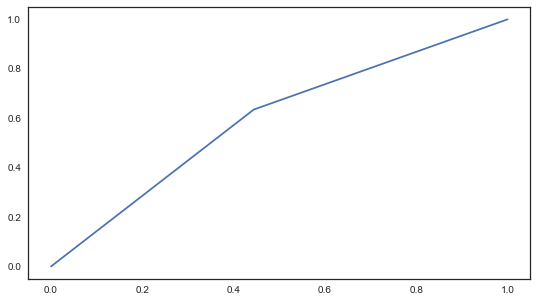

{'Model': 'Logistic', '3-fold CV Accuracy': 0.5897873508411694, 'Confusion Matrix': array([[25637, 20480],
       [17096, 29741]]), 'AUC Score': 0.59545078397736906}


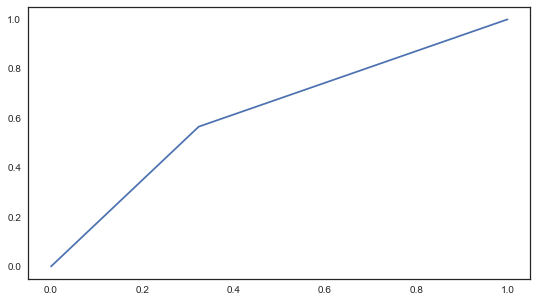

{'Model': 'Random Forest', '3-fold CV Accuracy': 0.61331703409307259, 'Confusion Matrix': array([[31196, 14921],
       [20339, 26498]]), 'AUC Score': 0.62110133468621254}


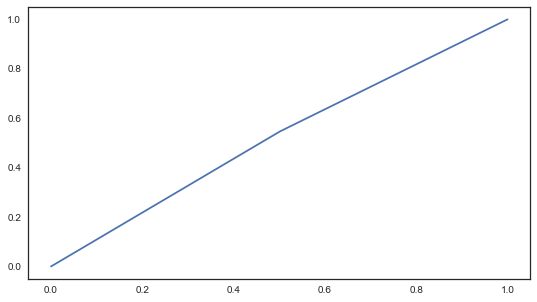

{'Model': 'KNN', '3-fold CV Accuracy': 0.52140243634769856, 'Confusion Matrix': array([[22992, 23125],
       [21244, 25593]]), 'AUC Score': 0.52249249280640619}


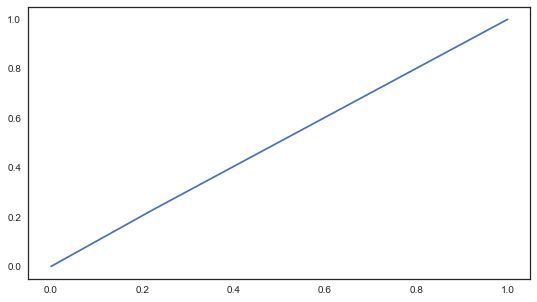

{'Model': 'Perceptron', '3-fold CV Accuracy': 0.49755192187945774, 'Confusion Matrix': array([[35821, 10296],
       [36093, 10744]]), 'AUC Score': 0.50306652935891294}


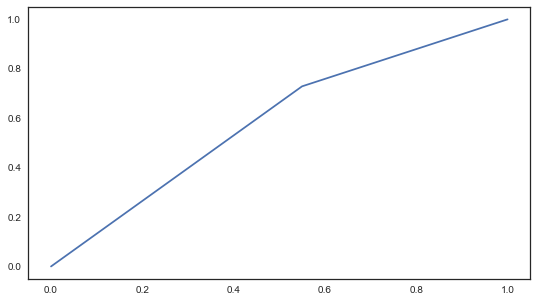

{'Model': 'Gaussian Naive Bayes', '3-fold CV Accuracy': 0.59111248758562818, 'Confusion Matrix': array([[20761, 25356],
       [12698, 34139]]), 'AUC Score': 0.58953530717247038}


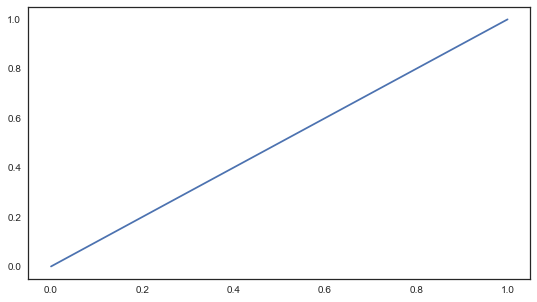

{'Model': 'Stochastic Gradient Descent', '3-fold CV Accuracy': 0.49944090660806406, 'Confusion Matrix': array([[35020, 11097],
       [35553, 11284]]), 'AUC Score': 0.50014676951494064}


In [26]:
models_lst = list()

for modl in [['Logistic',logit()], ['Random Forest',RFC(n_jobs=-1)], ['KNN',KNeighborsClassifier()], ['Perceptron',Perceptron()],['Gaussian Naive Bayes', GaussianNB()],['Stochastic Gradient Descent',SGDClassifier()]]:
    models_lst.append(modl_exp(modl[0], modl[1], X_train, Y_train, X_val, Y_val))


In [27]:
models_df = pd.DataFrame(models_lst)
models_df.set_index('Model',inplace=True)

In [28]:
models_df

,3-fold CV Accuracy,AUC Score,Confusion Matrix
Model,,,
Logistic,0.589787,0.595451,"[[25637, 20480], [17096, 29741]]"
Random Forest,0.613317,0.621101,"[[31196, 14921], [20339, 26498]]"
KNN,0.521402,0.522492,"[[22992, 23125], [21244, 25593]]"
Perceptron,0.497552,0.503067,"[[35821, 10296], [36093, 10744]]"
Gaussian Naive Bayes,0.591112,0.589535,"[[20761, 25356], [12698, 34139]]"
Stochastic Gradient Descent,0.499441,0.500147,"[[35020, 11097], [35553, 11284]]"


### c) Conclusion

## Fine Tuning

### a) Set-Up

In [29]:
train75_df = train.sample(frac=0.75)

ptrain75_df = pipe(train75_df)

X_train75 = ptrain75_df.drop("target", axis=1).copy()
Y_train75 = ptrain75_df["target"].copy()

### b) Random Forest Fine Tuning

##### Tuning: min_samples_leaf

In [30]:
leaf_sizes = [1,10,15,25,50,75,100]
acc_rfc_msl = list()

for samples in leaf_sizes:
    RFC_modl = RFC(n_jobs=-1, min_samples_leaf=samples)
    acc_rfc_msl.append(np.mean(CVS(RFC_modl, X_train75, Y_train75)))    

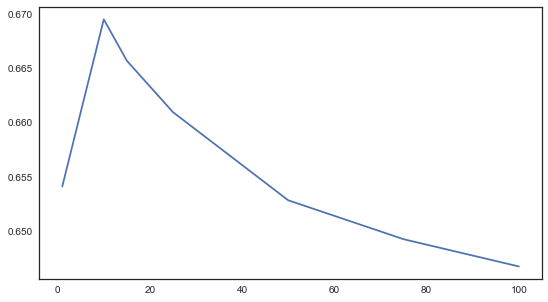

[0.6541412474870486, 0.66951117031172391, 0.66570825725400462, 0.66097533643249473, 0.65286836044006025, 0.64928930029669896, 0.64678277046928168]
Best leaf size: 10


In [31]:
plt.plot(leaf_sizes, acc_rfc_msl)
plt.show()
print(acc_rfc_msl)
best_leaf_size = leaf_sizes[acc_rfc_msl.index(max(acc_rfc_msl))]
print('Best leaf size:',best_leaf_size)

In [32]:
opt_leaf_size = 15

##### Tuning: max_features

In [33]:
features = ['auto','log2','sqrt',0.125,0.25,0.5,0.625,0.75]
acc_rfc_mf = list()

for max_feat in features:
    RFC_modl = RFC(n_jobs=-1, min_samples_leaf=opt_leaf_size, max_features=max_feat)
    acc_rfc_mf.append(np.mean(CVS(RFC_modl, X_train75, Y_train75)))
    print(max_feat)

auto
log2
sqrt
0.125
0.25
0.5
0.625
0.75


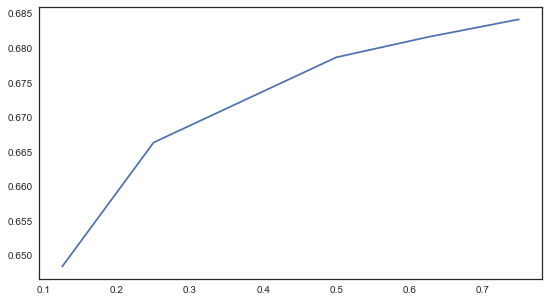

[0.66610664770183803, 0.66438347322732172, 0.66605113627121559, 0.64843003669716226, 0.66636742224728085, 0.67869093467328945, 0.68161960873866378, 0.6841893954109125]
Best max_features: 0.75


In [34]:
plt.plot(features[3:], acc_rfc_mf[3:])
plt.show()
print(acc_rfc_mf)
best_max_feat = features[acc_rfc_mf.index(max(acc_rfc_mf))]
print('Best max_features:',best_max_feat)

In [35]:
opt_max_feat = 0.75

##### Tuning: n_estimators

In [36]:
import time

n_trees = [10,15,20,25]
acc_rfc_ne = list()
speed = list()

i=0
for n_est in n_trees:
    RFC_modl = RFC(n_estimators=n_est,n_jobs=-1, min_samples_leaf=opt_leaf_size, max_features=opt_max_feat)
    
    start = time.time()
    acc_rfc_ne.append(np.mean(CVS(RFC_modl, X_train75, Y_train75)))
    end = time.time()
    
    speed.append(end-start)
    print(speed[i])
    i=i+1

209.92155838012695
251.82014966011047
357.15988540649414
463.8092646598816


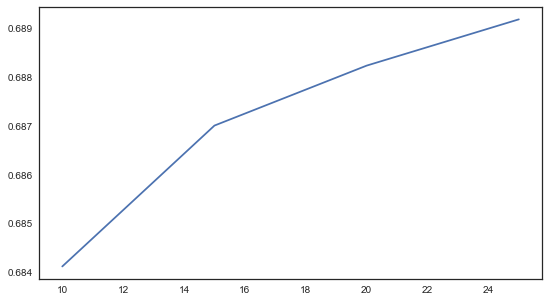

[0.68412510566636919, 0.68700730463962911, 0.68823371775224251, 0.68918025010611739]


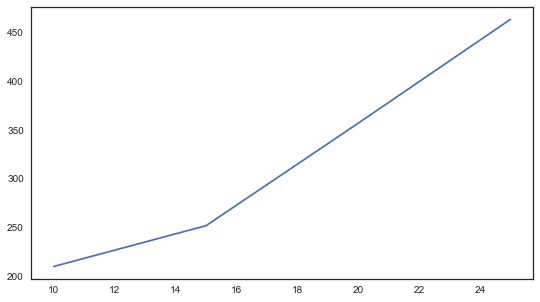

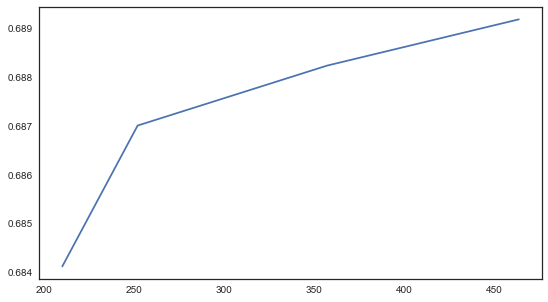

In [37]:
plt.plot(n_trees, acc_rfc_ne)
plt.show()
print(acc_rfc_ne)

plt.plot(n_trees, speed)
plt.show()

plt.plot(speed, acc_rfc_ne)
plt.show()

In [38]:
opt_n_estimators = 25

##### Final RFC Model

In [39]:
final_RFC = RFC(n_estimators=opt_n_estimators,n_jobs=-1, min_samples_leaf=opt_leaf_size, max_features=opt_max_feat)

### c) Logistic Regression Tuning

In [40]:
cs = [0.01,0.1,1,10]

acc_lr_c = list()

for c in cs:
    logit_modl = logit(C=c)
    acc_lr_c.append(np.mean(CVS(logit_modl, X_train75, Y_train75)))
    print(c)

0.01
0.1
1
10


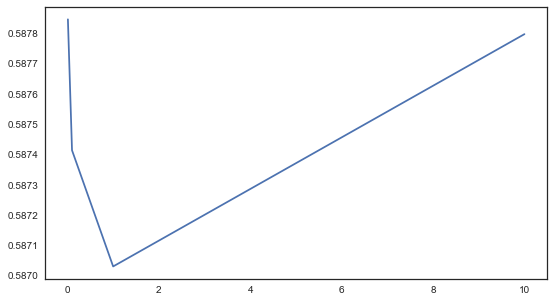

[0.58784627490857388, 0.58741406123400652, 0.58703064614678235, 0.58779747585285425]
Best c: 0.01


In [41]:
plt.plot(cs, acc_lr_c)
plt.show()
print(acc_lr_c)
best_c = cs[acc_lr_c.index(max(acc_lr_c))]
print('Best c:',best_c)

In [42]:
final_logit = logit(C=0.01,n_jobs=-1)

In [43]:
final_gnb = GaussianNB()

### d) Ensemble

In [44]:
models = [('RFC',final_RFC),('Logit',final_logit),('GNB',final_gnb)]

##### Hard voting

In [45]:
hard_vc = VC(models,voting='hard',n_jobs=-1)

In [46]:
CVS(hard_vc, X_train75, Y_train75)

array([ 0.6183432 ,  0.61789984,  0.61957263])

##### Soft voting

In [47]:
soft_vc = VC(models,voting='soft',n_jobs=-1)

In [48]:
CVS(soft_vc, X_train75, Y_train75)

array([ 0.65949564,  0.65879439,  0.6594711 ])

## Testing

In [49]:
ptrain_df = pipe(train)
ptest_df = pipe(test)

X_train = ptrain_df.drop("target", axis=1).copy()
Y_train = ptrain_df["target"].copy()

X_test = ptest_df.drop("target", axis=1).copy()
Y_test = ptest_df["target"].copy()

In [50]:
final_RFC.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.75, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [51]:
final_RFC.score(X_test,Y_test)

0.62924409630976441

In [52]:
y_pred = final_RFC.predict(X_test)
AUC(Y_test,y_pred)

0.62980183726622607